In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = "/content/drive/MyDrive/AI_RL_Task_Scheduling"
DATA_DIR = f"{PROJECT_ROOT}/data"
SRC_DIR = f"{PROJECT_ROOT}/src"
MODELS_DIR = f"{PROJECT_ROOT}/models"
OUTPUTS_DIR = f"{PROJECT_ROOT}/outputs"

sys.path.append(SRC_DIR)


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn

from sim_env import Task, Scheduler, SchedulerEnv, compute_metrics
from config import N_EVAL_TASKS, SEEDS, TOP_K


In [3]:
def load_tasks_jsonl(path):
    tasks = []
    with open(path, "r") as f:
        for line in f:
            d = json.loads(line)
            ptime = int(d["processing_time"])
            tasks.append(Task(
                task_id=int(d["task_id"]),
                arrival_time=int(d["arrival_time"]),
                processing_time=ptime,
                deadline=int(d["deadline"]),
                remaining_time=ptime
            ))
    return tasks

EVAL_WORKLOADS = ["uniform", "bursty", "heavy_tailed", "deadline_constrained"]

def eval_path(workload, seed):
    return f"{DATA_DIR}/{workload}_eval_seed{seed}.jsonl"


In [4]:
class FCFSScheduler(Scheduler):
    def select_task(self, ready_queue, t):
        return min(range(len(ready_queue)),
                   key=lambda i: (ready_queue[i].arrival_time, ready_queue[i].task_id))

class SJFScheduler(Scheduler):
    def select_task(self, ready_queue, t):
        return min(range(len(ready_queue)),
                   key=lambda i: (ready_queue[i].remaining_time,
                                  ready_queue[i].arrival_time,
                                  ready_queue[i].task_id))

class EDFScheduler(Scheduler):
    def select_task(self, ready_queue, t):
        return min(range(len(ready_queue)),
                   key=lambda i: (ready_queue[i].deadline,
                                  ready_queue[i].remaining_time,
                                  ready_queue[i].task_id))

class RoundRobinScheduler(Scheduler):
    def __init__(self):
        self.pointer = 0
    def select_task(self, ready_queue, t):
        if self.pointer >= len(ready_queue):
            self.pointer = 0
        idx = self.pointer
        self.pointer = (self.pointer + 1) % len(ready_queue)
        return idx


In [5]:
STATE_DIM = TOP_K * 3 + 2
ACTION_DIM = TOP_K

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )
    def forward(self, x):
        return self.net(x)


In [6]:
def get_sorted_view(ready_queue):
    return sorted(ready_queue, key=lambda x: (x.deadline, x.remaining_time, x.task_id))

def encode_state(ready_queue, t, max_deadline_horizon=200.0, max_wait=200.0, max_rem=50.0):
    rq = get_sorted_view(ready_queue)
    feats = []

    for i in range(TOP_K):
        if i < len(rq):
            rem = rq[i].remaining_time / max_rem
            ttd = (rq[i].deadline - t) / max_deadline_horizon
            wait = rq[i].waiting_time / max_wait
            feats.extend([rem, ttd, wait])
        else:
            feats.extend([0.0, 0.0, 0.0])

    qlen = len(ready_queue) / 50.0
    avg_wait = (np.mean([x.waiting_time for x in ready_queue]) if ready_queue else 0.0) / max_wait
    feats.extend([qlen, avg_wait])

    return np.array(feats, dtype=np.float32)

def valid_action_mask(ready_queue):
    m = np.zeros(TOP_K, dtype=np.bool_)
    m[:min(len(ready_queue), TOP_K)] = True
    return m


In [7]:
class DQNScheduler(Scheduler):
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_task(self, ready_queue, t):
        if not ready_queue:
            return 0
        rq_sorted = get_sorted_view(ready_queue)
        state = encode_state(ready_queue, t)
        mask = valid_action_mask(rq_sorted)

        with torch.no_grad():
            s = torch.tensor(state, device=self.device).unsqueeze(0)
            q = self.model(s).squeeze(0).detach().cpu().numpy()
            q[~mask] = -1e9
            a = int(np.argmax(q))

        chosen_task = rq_sorted[a]
        actual_idx = ready_queue.index(chosen_task)
        return actual_idx


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DQN(STATE_DIM, ACTION_DIM).to(device)
model_path = f"{MODELS_DIR}/dqn.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("Loaded model:", model_path, "| device:", device)


Loaded model: /content/drive/MyDrive/AI_RL_Task_Scheduling/models/dqn.pt | device: cpu


In [9]:
def run_one(scheduler, tasks):
    env = SchedulerEnv(tasks, scheduler, max_time=500000)
    completed = env.run()
    return compute_metrics(completed)

schedulers = {
    "FCFS": FCFSScheduler(),
    "SJF": SJFScheduler(),
    "EDF": EDFScheduler(),
    "RR": RoundRobinScheduler(),
    "DQN": DQNScheduler(model, device),
}

rows = []

for workload in EVAL_WORKLOADS:
    for seed in SEEDS:
        path = eval_path(workload, seed)
        base_tasks = load_tasks_jsonl(path)

        for sname, sched in schedulers.items():
            # IMPORTANT: make a fresh copy of tasks each run
            tasks = [Task(t.task_id, t.arrival_time, t.processing_time, t.deadline, remaining_time=t.processing_time)
                     for t in base_tasks]

            metrics = run_one(sched, tasks)
            rows.append({
                "workload": workload,
                "seed": seed,
                "scheduler": sname,
                **metrics
            })

df = pd.DataFrame(rows)
df.head()


,workload,seed,scheduler,avg_waiting_time,deadline_miss_rate,throughput
0,uniform,0,FCFS,2998.2600,0.9915,0.183436
1,uniform,0,SJF,1808.4340,0.4635,0.183436
2,uniform,0,EDF,2994.2155,0.9910,0.183436
3,uniform,0,RR,4185.9630,0.9860,0.183436
4,uniform,0,DQN,2998.7985,0.9905,0.183436


In [10]:
agg = df.groupby(["workload", "scheduler"]).agg(
    avg_waiting_time_mean=("avg_waiting_time", "mean"),
    avg_waiting_time_std=("avg_waiting_time", "std"),
    deadline_miss_rate_mean=("deadline_miss_rate", "mean"),
    deadline_miss_rate_std=("deadline_miss_rate", "std"),
    throughput_mean=("throughput", "mean"),
    throughput_std=("throughput", "std"),
).reset_index()

out_csv = f"{OUTPUTS_DIR}/results_summary.csv"
agg.to_csv(out_csv, index=False)

print("Saved:", out_csv)
agg


Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/results_summary.csv


,workload,scheduler,avg_waiting_time_mean,avg_waiting_time_std,deadline_miss_rate_mean,deadline_miss_rate_std,throughput_mean,throughput_std
0,bursty,DQN,5434.912500,81.244270,0.997167,0.000577,0.154735,0.001408
1,bursty,EDF,5434.590500,83.043113,0.997000,0.000000,0.154735,0.001408
2,bursty,FCFS,5447.866000,83.351262,0.997833,0.000289,0.154735,0.001408
3,bursty,RR,7323.811500,167.104264,0.989500,0.007000,0.154735,0.001408
4,bursty,SJF,3569.813167,87.855956,0.704333,0.013549,0.154735,0.001408
5,deadline_constrained,DQN,3946.116000,75.547932,0.997500,0.003041,0.182250,0.001336
6,deadline_constrained,EDF,3943.281667,74.672182,0.998000,0.000500,0.182250,0.001336
7,deadline_constrained,FCFS,3949.559333,74.843253,0.998833,0.000289,0.182250,0.001336
8,deadline_constrained,RR,5446.000333,90.809104,0.994667,0.002754,0.182250,0.001336
9,deadline_constrained,SJF,2531.610333,47.924057,0.651333,0.002021,0.182250,0.001336


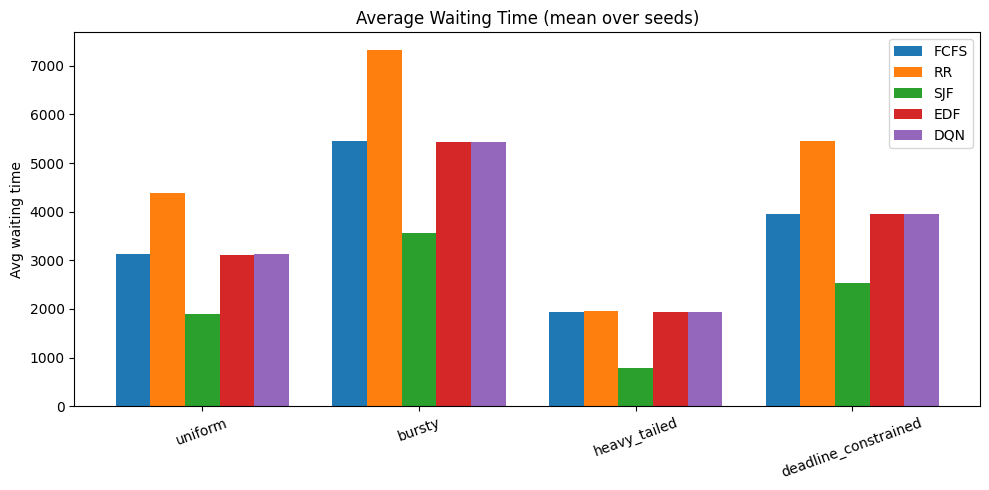

Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/results_waiting.png


In [11]:
def plot_metric(metric_col, title, ylabel, out_name):
    workloads = EVAL_WORKLOADS
    sched_order = ["FCFS", "RR", "SJF", "EDF", "DQN"]

    fig, ax = plt.subplots(figsize=(10,5))
    x = np.arange(len(workloads))
    width = 0.16

    for i, s in enumerate(sched_order):
        sub = agg[agg["scheduler"] == s].set_index("workload").loc[workloads]
        ax.bar(x + (i-2)*width, sub[metric_col].values, width, label=s)

    ax.set_xticks(x)
    ax.set_xticklabels(workloads, rotation=20)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.tight_layout()

    out_path = f"{OUTPUTS_DIR}/{out_name}"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)

plot_metric("avg_waiting_time_mean", "Average Waiting Time (mean over seeds)", "Avg waiting time", "results_waiting.png")


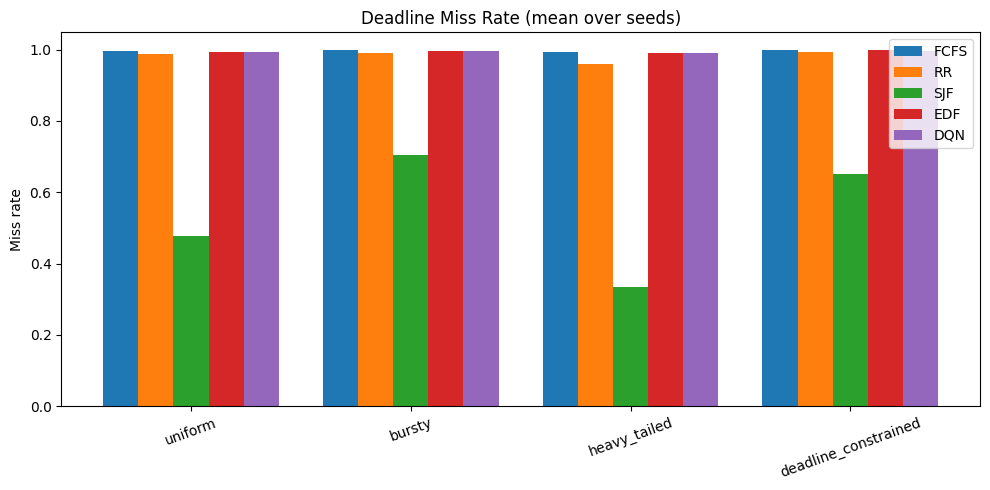

Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/results_missrate.png


In [12]:
plot_metric("deadline_miss_rate_mean", "Deadline Miss Rate (mean over seeds)", "Miss rate", "results_missrate.png")


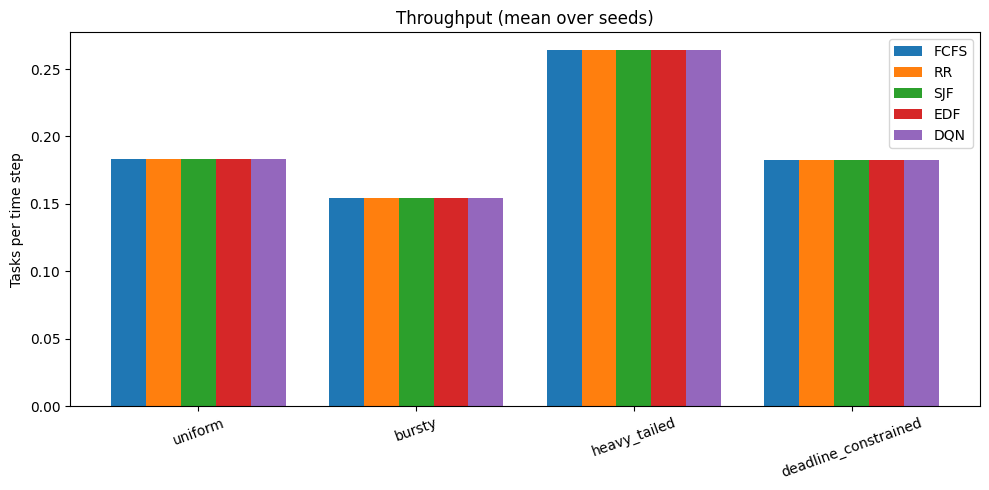

Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/results_throughput.png


In [13]:
plot_metric("throughput_mean", "Throughput (mean over seeds)", "Tasks per time step", "results_throughput.png")


In [14]:
def fmt(mean, std, decimals=3):
    if np.isnan(std):
        std = 0.0
    return f"{mean:.{decimals}f} ± {std:.{decimals}f}"

table_rows = []
for workload in EVAL_WORKLOADS:
    for sched in ["FCFS", "RR", "SJF", "EDF", "DQN"]:
        sub = agg[(agg.workload == workload) & (agg.scheduler == sched)].iloc[0]
        table_rows.append({
            "Workload": workload,
            "Scheduler": sched,
            "AvgWait": fmt(sub.avg_waiting_time_mean, sub.avg_waiting_time_std, 2),
            "MissRate": fmt(sub.deadline_miss_rate_mean, sub.deadline_miss_rate_std, 3),
            "Throughput": fmt(sub.throughput_mean, sub.throughput_std, 3),
        })

tbl = pd.DataFrame(table_rows)

latex = tbl.to_latex(index=False, escape=False)
tex_path = f"{OUTPUTS_DIR}/results_table.tex"
with open(tex_path, "w") as f:
    f.write(latex)

print("Saved LaTeX table:", tex_path)
tbl.head(10)


Saved LaTeX table: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/results_table.tex


,Workload,Scheduler,AvgWait,MissRate,Throughput
0,uniform,FCFS,3121.05 ± 137.01,0.995 ± 0.003,0.184 ± 0.002
1,uniform,RR,4383.05 ± 232.81,0.988 ± 0.002,0.184 ± 0.002
2,uniform,SJF,1899.71 ± 111.61,0.478 ± 0.019,0.184 ± 0.002
3,uniform,EDF,3117.13 ± 136.94,0.995 ± 0.003,0.184 ± 0.002
4,uniform,DQN,3121.03 ± 135.79,0.993 ± 0.002,0.184 ± 0.002
5,bursty,FCFS,5447.87 ± 83.35,0.998 ± 0.000,0.155 ± 0.001
6,bursty,RR,7323.81 ± 167.10,0.990 ± 0.007,0.155 ± 0.001
7,bursty,SJF,3569.81 ± 87.86,0.704 ± 0.014,0.155 ± 0.001
8,bursty,EDF,5434.59 ± 83.04,0.997 ± 0.000,0.155 ± 0.001
9,bursty,DQN,5434.91 ± 81.24,0.997 ± 0.001,0.155 ± 0.001
